In [ ]:
import face_utils
from time import sleep

In [ ]:
import requests
import re
from selenium import webdriver
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time

def get_links(subject_name):
    header = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64; rv:70.0) Gecko/20100101 Firefox/70.0","Cookie": 'sb=ufgMXRKi5bcIfSSMaIelRh5G; datr=ufgMXdM8hrLb-psr4lJbZwMo; c_user=100004912332911; xs=33%3AnSUFMmc3rtO1kg%3A2%3A1569653696%3A15717%3A8272; spin=r.1001436623_b.trunk_t.1573795693_s.1_v.2_; fr=0WfA239LUIWQj54ZH.AWX55JfOK3_vBs2e71NqKaucnlE.Bc8pR5.Ea.AAA.0.0.Bdz4xe.AWVLIfVN; presence=EDvF3EtimeF1573883961EuserFA21B04912332911A2EstateFDt3F_5bDiFA2user_3a1B07388262849A2EoF1EfF1C_5dEutc3F1573730942948G573883961180CEchFDp_5f1B04912332911F1CC; wd=616x657; act=1573884013894%2F10'}
    htm = requests.get("https://www.facebook.com/search/people/?q="+subject_name,headers = header)
    profiles = list()
    for a in re.findall(r'<a title="[A-Za-z0-9 ]+" class="_32mo" .*?>',str(htm.content)) :
        profiles.append((a.split('"')[1], a.split('"')[5]))

    return profiles

chrome_options = webdriver.ChromeOptions()
prefs = {"profile.default_content_setting_values.notifications" : 2}
chrome_options.add_experimental_option("prefs",prefs)
# chrome_options.add_argument("--headless")

driver = webdriver.Chrome("/home/archer/Documents/OSINT_India_Police_Hackathon/chromedriver",chrome_options=chrome_options)
driver.maximize_window()
print("Logging in....")
driver.get("https://www.facebook.com/siddharth.mahajan.79")
element = driver.find_element_by_id("email")
element.send_keys(FBEMAIL)
element = driver.find_element_by_id("pass")
element.send_keys(FBPASS)
element = driver.find_element_by_id("loginbutton")
element.click()
print("Logged in....")

def fetch_screen(name):
    profiles = get_links(name)[:5]
    count = 1
    linkandpic = []
    for name,link in profiles:
        print("Fetching profile ",count)
        driver.get(link)
        driver.find_element_by_xpath("//*[@data-tab-key='photos']").click()
        imct=1
        driver.execute_script("window.scrollTo(0, 500)")
        linkandpic.append([link,[]])
        while imct<=2:
            time.sleep(2.5)
            fname="Screenshot/"+str(count)+"_"+str(imct)+".png"
            driver.save_screenshot(fname)
            linkandpic[-1][1].append(fname)
            driver.execute_script("window.scrollTo(500,1000)")
            imct+=1
        count +=1
    return linkandpic

In [35]:
lnpc=fetch_screen("Siddharth Mahajan")

Fetching profile  1
Fetching profile  2
Fetching profile  3
Fetching profile  4
Fetching profile  5


In [36]:
recs=[]
for i in lnpc:
    recs.append(i[1])

In [37]:
import importlib

In [38]:
pidx=face_utils.count_targets(["sid.jpg"],recs)

['TARGET', 'TARGET', 'TARGET', 'TARGET', 'Unknown', 'TARGET', 'Unknown', 'TARGET', 'TARGET', 'TARGET', 'TARGET']
[]
['Unknown']
[]
[]


In [9]:
profile_link=lnpc[pidx][0].split("?ref")[0]
print("Profile Link:",profile_link)

Profile Link: https://www.facebook.com/siddharth.mahajan.79


In [10]:
username=profile_link.split("facebook.com/")[1]
print("Username:",username)

Username: siddharth.mahajan.79


In [11]:
sections = {
    'photo_url': {'src':'//div[@id="objects_container"]//a/img[@alt][1]'},
    'tagline': {'txt':'//*[@id="root"]/div[1]/div[1]/div[2]/div[2]'},
    'about': {'txt':'//div[@id="bio"]/div/div[2]/div'},
    'quotes': {'txt':'//*[@id="quote"]/div/div[2]/div'},
    'rel': {'txt':'//div[@id="relationship"]/div/div[2]'},
    'rel_partner': {'href':'//div[@id="relationship"]/div/div[2]//a'},
    'details': {'table':'(//div[2]/div//div[@title]//'},
    'work': {'workedu':'//*[@id="work"]/div[1]/div[2]/div'},
    'education': {'workedu':'//*[@id="education"]/div[1]/div[2]/div'},
    'family': {'fam':'//*[@id="family"]/div/div[2]/div'},
    'life_events': {'years':'(//div[@id="year-overviews"]/div[1]/div[2]/div[1]/div/div[1])'}
}
driver.get("https://mbasic.facebook.com/"+username+"/about")
name=driver.find_element_by_xpath('/html/body/div/div/div[2]/div/div[1]/div[1]/div[2]/div[1]/span/div/span/strong')
d = {'name': name.text}
x = driver.find_element_by_xpath
xs = driver.find_elements_by_xpath
for k,v in sections.items():
    try:
        if 'src' in v:
            d[str(k)] = x(v['src']).get_attribute('src')
        elif 'txt' in v:
            d[str(k)] = x(v['txt']).text
        elif 'href' in v:
            d[str(k)] = x(v['href']).get_attribute('href')[8:].split('?')[0]
        elif 'table' in v:
            d['details'] = []
            rows = xs(v['table']+'td[1])')
            for i in range (1, len(rows)+1):
                deets_key = x(v['table']+'td[1])'+'['+str(i)+']').text
                deets_val = x(v['table']+'td[2])'+'['+str(i)+']').text
                d['details'].append({deets_key:deets_val})
        elif 'workedu' in v:
            d[str(k)] = []
            base = v['workedu']
            rows = xs(base)
            for i in range (1, len(rows)+1):
                dd = {}
                dd['link'] = x(base+'['+str(i)+']'+'/div/div[1]//a').get_attribute('href')[8:].split('&')[0].split('/')[0]
                dd['org'] = x(base+'['+str(i)+']'+'/div/div[1]//a').text
                dd['lines'] = []
                lines = xs(base+'['+str(i)+']'+'/div/div[1]/div')
                for l in range (2, len(lines)+1):
                    line = x(base+'['+str(i)+']'+'/div/div[1]/div'+'['+str(l)+']').text
                    dd['lines'].append(line)
                d[str(k)].append(dd)
        elif 'fam' in v:
            d[str(k)] = []
            base = v['fam']
            rows = xs(base)
            for i in range (1, len(rows)+1):
                d[str(k)].append({
                    'name': x(base+'['+str(i)+']'+'//h3[1]').text,
                    'rel': x(base+'['+str(i)+']'+'//h3[2]').text,
                    'alias': x(base+'['+str(i)+']'+'//h3[1]/a').get_attribute('href')[8:].split('?')[0]
                })
        elif 'life_events' in k:
            d[str(k)] = []
            base = v['years']
            years = xs(base)
            for i in range (1,len(years)+1):
                year = x(base+'['+str(i)+']'+'/div[1]').text
                events = xs(base+'['+str(i)+']'+'/div/div/a')
                for e in range(1,len(events)+1):
                    event = x('('+base+'['+str(i)+']'+'/div/div/a)'+'['+str(e)+']')
                    d[str(k)].append({
                        'year': year,
                        'title': event.text,
                        'link': event.get_attribute('href')[8:].split('refid')[0]
                    })
    except Exception:
        pass

In [11]:
for key in d.keys():
    print(key.upper(),": ",end="")
    if type(d[key]) is list:
        print("\n",end="")
        for itm in d[key]:
            if type(itm) is dict:
                for kff in itm.keys():
                    print("\t",kff.upper(),":",itm[kff])
    else:
        print(d[key])

NAME : Siddharth Mahajan
PHOTO_URL : https://scontent.fhyd12-1.fna.fbcdn.net/v/t1.0-1/cp0/e15/q65/c0.0.74.74a/p74x74/50047032_2267573016832285_427191015061848064_o.jpg?_nc_cat=101&efg=eyJpIjoiYiJ9&_nc_oc=AQk2BRau_Ft6atFsDyYdmLxSn9Vc1C7xFlCFxsWR5_wdoAZjrYDEORMwp_BmPiwKf9g&_nc_ht=scontent.fhyd12-1.fna&oh=e6fd3417c81c959460f798e4af288ff2&oe=5E4A186E
TAGLINE : The BIG Bang Theory FAN 🔥🔥 , CAMILA CABELLO FAN 🔥🔥, MALUMA FAN🔥🔥!!
..LIFE IS A GARDEN, DIG IT!!
REL : Single
DETAILS : 
	 CURRENT CITY : Jammu
	 MOVED IN 2010 : Mumbai, Maharashtra
	 HOME TOWN : Jammu
	 FACEBOOK : /siddharth.mahajan.79
	 BIRTHDAY : 24 March 1999
	 GENDER : Male
WORK : 
	 LINK : mbasic.facebook.com
	 ORG : MIT World Peace University
	 LINES : ['Studying', '22 July 2017 - Present', 'Pune, Maharashtra']
	 LINK : mbasic.facebook.com
	 ORG : jodhamal public school,jammu
	 LINES : ['Student', '12 April 2005 - Present']
EDUCATION : 
	 LINK : mbasic.facebook.com
	 ORG : jodhamal public school
	 LINES : ['High School']
	 LINK

In [1]:
from twitter import *
import requests

In [2]:
twitter_consumer_key = APPROPRIATE_TWITTER_KEYS
twitter_consumer_secret = APPROPRIATE_TWITTER_KEYS
twitter_access_token = APPROPRIATE_TWITTER_KEYS
twitter_access_secret = APPROPRIATE_TWITTER_KEYS

In [3]:
tpi=Twitter(auth=OAuth(twitter_access_token,twitter_access_secret,twitter_consumer_key,twitter_consumer_secret))

In [4]:
res=tpi.statuses.user_timeline(screen_name="RahulGandhi",count=50)

In [5]:
import os
import re
import json
from bs4 import BeautifulSoup
from urllib.parse import quote,unquote
from html import unescape

In [6]:
query=res[0]['text'][:-24]
query

'Modinomics stinks so bad, the Govt has to hide its own reports.'

In [9]:
with open("curlcmd","r") as f:
    ccmd=f.read()
rcmd=ccmd.replace("REPLACEME",quote(query))
anl=os.popen(rcmd).read()

In [10]:
soup=BeautifulSoup(anl)
f=soup.find('pre').get_text()
df=json.loads(f)

In [11]:
def disptextAnalytics(df):
    for lng in df['languageDetection']['documents'][0]['detectedLanguages']:
        print("LANG:\t",lng['name'])
    for kp in df['keyPhrases']['documents']:
        print("KeyPhrases:\t",kp['keyPhrases'])
    print("Sentiment Score:",df['sentiment']['documents'][0]['score'])
    for ent in df['entities']['documents'][0]['entities']:
        for key in ent.keys():
            print(key.upper(),":",ent[key])
disptextAnalytics(df)

LANG:	 English
KeyPhrases:	 ['Govt', 'Modinomics stinks', 'reports']
Sentiment Score: 0.018424302339553833
NAME : Narendra Modi
MATCHES : [{'text': 'Modinomics', 'offset': 0, 'length': 10}]
WIKIPEDIALANGUAGE : en
WIKIPEDIAID : Narendra Modi
WIKIPEDIAURL : https://en.wikipedia.org/wiki/Narendra_Modi
BINGID : 04fee623-e9bd-ee4b-f30d-cad3c29199e4
TYPE : Person
SUBTYPE : None
NAME : Government
MATCHES : [{'text': 'Govt', 'offset': 30, 'length': 4}]
WIKIPEDIALANGUAGE : en
WIKIPEDIAID : Government
WIKIPEDIAURL : https://en.wikipedia.org/wiki/Government
BINGID : 5634d914-4190-dd0b-fa80-715c2ac46335
TYPE : Other
SUBTYPE : None


In [15]:
from threading import Thread
from time import sleep

In [16]:
neg=pos=neut=0
kphrases=[]

def textApiThread(r,inrecur=False):
    global pos,neg,neut
    query=unescape(r)
    rcmd=ccmd.replace("REPLACEME",quote(query))
    anl=os.popen(rcmd).read()
    soup=BeautifulSoup(anl)
    try:
        f=soup.find('pre')
        if f is None:
            print("\nFix request headers !")
            return
        df=json.loads(f.get_text())
        snt=float(df['sentiment']['documents'][0]['score'])
        if snt<0.4:
            neg+=1
        elif snt>0.6:
            pos+=1
        else:
            neut+=1
        for kp in df['keyPhrases']['documents']:
            for kk in kp['keyPhrases']:
                kphrases.append(kk)
#         disptextAnalytics(df)
    except Exception:
        pass

thrds=[]
def textApi(res):
    for idx,r in enumerate(res):
        print('\r',idx+1,end="")
        thrds.append(Thread(target=textApiThread,args=(r['text'][:-24],)))
        thrds[-1].setDaemon(True)
        thrds[-1].start()
        sleep(0.5)
    for t in thrds:
        t.join()
        
textApi(res)

 7
Fix request headers !
 9
Fix request headers !
 13
Fix request headers !
 36
Fix request headers !
 50

In [17]:
import matplotlib.pyplot as plt

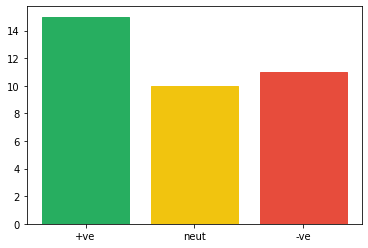

In [18]:
p=plt.bar(['+ve','neut','-ve'],height=[pos,neut,neg])
p[0].set_color('#27ae60')
p[1].set_color('#f1c40f')
p[2].set_color('#e74c3c')

In [19]:
kpdt=dict.fromkeys(kphrases,0)

In [20]:
for kp in kphrases:
    kpdt[kp]+=1

In [21]:
sorted(kpdt.items(), key=lambda x: x[1], reverse=True)

[('PM', 4),
 ('Govt', 2),
 ('time', 2),
 ('public meeting', 2),
 ('Haryana', 2),
 ('public meetings', 2),
 ('Maharashtra', 2),
 ('Wayanad', 2),
 ('solidarity', 2),
 ('youth', 2),
 ('Modinomics stinks', 1),
 ('reports', 1),
 ('huge door', 1),
 ('Supreme Court', 1),
 ('investigation', 1),
 ('RAFALE scam', 1),
 ('Justice Joseph', 1),
 ('statesman', 1),
 ('Pandit Jawaharlal Nehru Ji', 1),
 ('visionary', 1),
 ('scholar', 1),
 ('birth anniversary', 1),
 ('Election Commissioners', 1),
 ('Shri', 1),
 ('Demonetisation terror attack', 1),
 ('Indian economy', 1),
 ('yrs', 1),
 ('lives', 1),
 ('Modi Minar races', 1),
 ('breathtaking pace', 1),
 ('passing month', 1),
 ('monument', 1),
 ('incompetence', 1),
 ('worth of goods', 1),
 ('Indian', 1),
 ('year', 1),
 ('Rs', 1),
 ('Realpolit', 1),
 ('Pegasus', 1),
 ('Indian citizens', 1),
 ('WhatsAop’s response', 1),
 ('Modi', 1),
 ('Dassault', 1),
 ('passing of baby Sujith', 1),
 ('condolences', 1),
 ('grieving parents', 1),
 ('Indian MPs', 1),
 ('Kashmir

In [39]:
proxies = {'http': "socks5://127.0.0.1:9050"}

In [ ]:
r=requests.get("http://hss3uro2hsxfogfq.onion/index.php?q=gandhi",proxies=proxies)